## Code for simulating SDE model

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats
import matplotlib.pyplot as plt
import random

In [2]:
# Baseline parameters
def param_init():
    R0 = 16
    gamma = 365/14
    mu = 1/60
    kappa = 3000
    delta = 3e-4
    N1 = 1000
    N2 = 19000
    h = 0.8
    c = 150
    tau = 60000
    post_prob = 0.2
    param = {'R0':R0, 'gamma':gamma, 'mu':mu, 'kappa':kappa, 'delta':delta, 'N1':N1, 'N2':N2, 'h':h, 'c':c,
             'tau':tau, 'post_prob':post_prob}
    return param

In [3]:
def valid_plot(I, threshold):
    return max(I) <= threshold

In [4]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [5]:
def levy_sde(param, ic, sigma, tf, dt):
    # ic: list of initial conditions
    # tf: final time
    # dt: timestep
    
    R0 = param['R0']
    gamma = param['gamma']
    mu = param['mu']
    beta = R0*(gamma+mu)
    kappa = param['kappa']
    delta = param['delta']
    N1 = param['N1']
    N2 = param['N2']
    h = param['h']
    c = param['c']
    tau = param['tau']
    
    s, i, x1, x2 = ic[0], ic[1], ic[2], ic[3]
    x = (x1*N1 + x2*N2)/(N1 + N2)
    k = 0
    tw_orig = c*x1*(1-x1) + tau*i
    sig = 2 + 1.2*sigmoid((tw_orig - 50)/20)
    rt = min(scipy.stats.levy_stable.rvs(alpha=1.2, beta=0.5, scale=sig, loc=(1-k)*tw_orig), 5*tw_orig)
    tw = max(k*tw_orig+rt,0)
    
    S, I, X1, X2, X, Tw = [s], [i], [x1], [x2], [x], [tw]
    
    tot = int(tf/dt)
    alpha = 1.5
    r = scipy.stats.levy_stable.rvs(alpha=alpha, beta=0, size=tot)

    t = 0
    j = 1
    T = [t]
    while j <= tot:
        t += dt
        
        omega = (t*0.5 + 2)*1e-4

        A1 = -omega + i + delta*(2*x1-1 + (1-h)*(2*x2-1))
        A2 = -omega + i + delta*(2*x2-1 + (1-h)*(2*x1-1))
        A3 = -omega + i + delta*(2-h)*(x1+x2-1)

        f_s = mu*(1-x) - beta*s*i - mu*s
        f_i = beta*s*i - (gamma+mu)*i
        f_x1 = kappa*x1*(1-x1)*A1 + (1-h)*kappa*(x2*(1-x1)*max(A3,0) - (1-x2)*x1*max(-A3,0))
        f_x2 = kappa*x2*(1-x2)*A2 + (1-h)*kappa*(x1*(1-x2)*max(A3,0) - (1-x1)*x2*max(-A3,0))

        dL = r[j-1]

        s = min(max(s + f_s*dt + (dt**(1/alpha))*sigma[0]*dL, 0), 1)
        i = min(max(i + f_i*dt + (dt**(1/alpha))*sigma[1]*dL, 0), 1)
        x1 = min(max(x1 + f_x1*dt + (dt**(1/alpha))*sigma[2]*dL, 0), 1)
        x2 = min(max(x2 + f_x2*dt + (dt**(1/alpha))*sigma[3]*dL, 0), 1)
        x = (x1*N1 + x2*N2)/(N1 + N2)

        tw_orig = c*x1*(1-x1) + tau*i
        
        prob = np.random.uniform()
        if Tw[-1] < 10:
            post_prob = param['post_prob']
        elif (Tw[-1] >= 10 and Tw[-1] < 50):
            post_prob = param['post_prob'] + 0.2
        else:
            post_prob = param['post_prob'] + 0.5
        
        k = 0.1
        sig = 3+1.5*sigmoid((tw_orig-50)/20)
        rt = min(scipy.stats.levy_stable.rvs(alpha=1.2, beta=0.5, scale=sig, loc=(1-k)*tw_orig), 5*tw_orig)
        tw = max(k*tw_orig+rt,0)
        if prob >= post_prob:
            tw = sum(np.random.binomial(1, 0.1, int(max(k*tw_orig+rt,0))))

        T.append(t)
        S.append(s)
        I.append(i)
        X1.append(x1)
        X2.append(x2)
        X.append(x)
        Tw.append(tw)
        
        j += 1

    return T, S, I, X1, X2, X, Tw

In [6]:
# For the convenience of demonstration, we run a relatively small number of simulations
# To obtain a better result, try increasing the following number
num_simu = 10

In [7]:
#[1e-3, 2e-6, 4e-3, 1e-3], 1:19 (baseline)
df1_s = pd.DataFrame()
df1_i = pd.DataFrame()
df1_x1 = pd.DataFrame()
df1_x2 = pd.DataFrame()
df1_x = pd.DataFrame()
df1_tw = pd.DataFrame()

for i in range(num_simu):
    check = False
    param = param_init()
    param['N1'] = 1000
    param['N2'] = 19000
    while not(check):
        T_sto, S_sto, I_sto, X1_sto, X2_sto, X_sto, Tw_sto = levy_sde(param, [0.01, 1e-6, 0.99, 0.99], [1e-3, 2e-6, 4e-3, 1e-3], 25, 1e-3)
        check = valid_plot(I_sto, 1e-2)  # get rid of very abnormal scenarios
    df = pd.DataFrame.from_dict({'time':T_sto, 'S':S_sto, 'I':I_sto, 'X1':X1_sto, 'X2':X2_sto, 'X':X_sto, 'Tw':Tw_sto})
    df1_s[i] = df['S']
    df1_i[i] = df['I']
    df1_x1[i] = df['X1']
    df1_x2[i] = df['X2']
    df1_x[i] = df['X']
    df1_tw[i] = df['Tw']

In [8]:
#[1e-3, 2e-6, 2e-2, 1e-3], 1:19
df2_s = pd.DataFrame()
df2_i = pd.DataFrame()
df2_x1 = pd.DataFrame()
df2_x2 = pd.DataFrame()
df2_x = pd.DataFrame()
df2_tw = pd.DataFrame()

for i in range(num_simu):
    check = False
    param = param_init()
    param['N1'] = 1000
    param['N2'] = 19000
    while not(check):
        T_sto, S_sto, I_sto, X1_sto, X2_sto, X_sto, Tw_sto = levy_sde(param, [0.01, 1e-6, 0.99, 0.99], [1e-3, 2e-6, 2e-2, 1e-3], 25, 1e-3)
        check = valid_plot(I_sto, 1e-2)
    df = pd.DataFrame.from_dict({'time':T_sto, 'S':S_sto, 'I':I_sto, 'X1':X1_sto, 'X2':X2_sto, 'X':X_sto, 'Tw':Tw_sto})
    df2_s[i] = df['S']
    df2_i[i] = df['I']
    df2_x1[i] = df['X1']
    df2_x2[i] = df['X2']
    df2_x[i] = df['X']
    df2_tw[i] = df['Tw']

In [9]:
#[1e-3, 2e-6, 4e-3, 1e-3], 2:3
df3_s = pd.DataFrame()
df3_i = pd.DataFrame()
df3_x1 = pd.DataFrame()
df3_x2 = pd.DataFrame()
df3_x = pd.DataFrame()
df3_tw = pd.DataFrame()

for i in range(num_simu):
    check = False
    param = param_init()
    param['N1'] = 8000
    param['N2'] = 12000
    while not(check):
        T_sto, S_sto, I_sto, X1_sto, X2_sto, X_sto, Tw_sto = levy_sde(param, [0.01, 1e-6, 0.99, 0.99],[1e-3, 2e-6, 4e-3, 1e-3], 25, 1e-3)
        check = valid_plot(I_sto, 1e-2)
    df = pd.DataFrame.from_dict({'time':T_sto, 'S':S_sto, 'I':I_sto, 'X1':X1_sto, 'X2':X2_sto, 'X':X_sto, 'Tw':Tw_sto})
    df3_s[i] = df['S']
    df3_i[i] = df['I']
    df3_x1[i] = df['X1']
    df3_x2[i] = df['X2']
    df3_x[i] = df['X']
    df3_tw[i] = df['Tw']

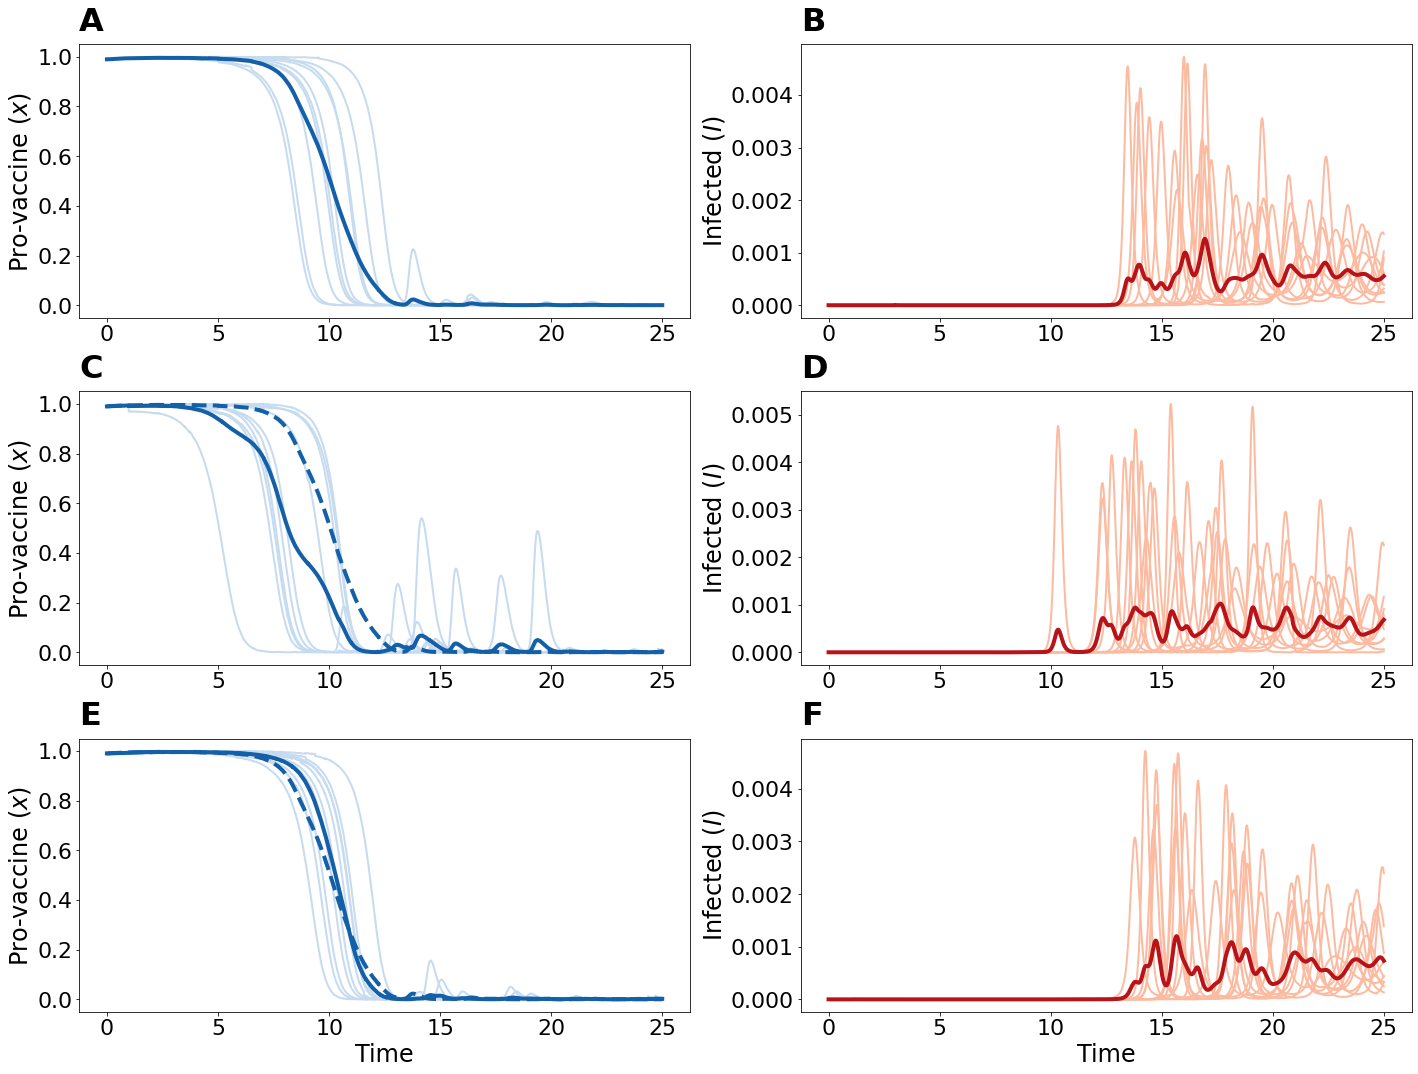

In [10]:
fig1, ax1 = plt.subplots(nrows=3, ncols=2, figsize=(20,15))
for i in random.sample(range(0, num_simu), 10):
    ax1[0,0].plot(df['time'], df1_x[i], label=r'$X$', linewidth=2, color=plt.cm.Blues(64))
    ax1[0,1].plot(df['time'], df1_i[i], label=r'$I$', linewidth=2, color=plt.cm.Reds(64))
    ax1[1,0].plot(df['time'], df2_x[i], label=r'$X$', linewidth=2, color=plt.cm.Blues(64))
    ax1[1,1].plot(df['time'], df2_i[i], label=r'$I$', linewidth=2, color=plt.cm.Reds(64))
    ax1[2,0].plot(df['time'], df3_x[i], label=r'$X$', linewidth=2, color=plt.cm.Blues(64))
    ax1[2,1].plot(df['time'], df3_i[i], label=r'$I$', linewidth=2, color=plt.cm.Reds(64))

ax1[0,0].plot(df['time'], df1_x.mean(axis=1), label=r'$X$', linewidth=4, color=plt.cm.Blues(208))
ax1[0,1].plot(df['time'], df1_i.mean(axis=1), label=r'$I$', linewidth=4, color=plt.cm.Reds(208))
ax1[1,0].plot(df['time'], df2_x.mean(axis=1), label=r'$X$', linewidth=4, color=plt.cm.Blues(208))
ax1[1,0].plot(df['time'], df1_x.mean(axis=1), label=r'$X$', linewidth=4, color=plt.cm.Blues(208), linestyle='--')
ax1[1,1].plot(df['time'], df2_i.mean(axis=1), label=r'$I$', linewidth=4, color=plt.cm.Reds(208))
ax1[2,0].plot(df['time'], df3_x.mean(axis=1), label=r'$X$', linewidth=4, color=plt.cm.Blues(208))
ax1[2,0].plot(df['time'], df1_x.mean(axis=1), label=r'$X$', linewidth=4, color=plt.cm.Blues(208), linestyle='--')
ax1[2,1].plot(df['time'], df3_i.mean(axis=1), label=r'$I$', linewidth=4, color=plt.cm.Reds(208))

for ax in ax1.flat:
    ax.tick_params(axis='both', which='major', labelsize=22)

ax1[0,0].set_ylabel('Pro-vaccine ($x$)', fontsize=24)
ax1[1,0].set_ylabel('Pro-vaccine ($x$)', fontsize=24)
ax1[2,0].set_ylabel('Pro-vaccine ($x$)', fontsize=24)

ax1[0,1].set_ylabel('Infected ($I$)', fontsize=24)
ax1[1,1].set_ylabel('Infected ($I$)', fontsize=24)
ax1[2,1].set_ylabel('Infected ($I$)', fontsize=24)
    
ax1[2,0].set_xlabel('Time', fontsize=24)
ax1[2,1].set_xlabel('Time', fontsize=24)

ax1[0,0].text(0, 1.05, 'A', transform=ax1[0,0].transAxes, size=32, weight='bold')
ax1[0,1].text(0, 1.05, 'B', transform=ax1[0,1].transAxes, size=32, weight='bold')
ax1[1,0].text(0, 1.05, 'C', transform=ax1[1,0].transAxes, size=32, weight='bold')
ax1[1,1].text(0, 1.05, 'D', transform=ax1[1,1].transAxes, size=32, weight='bold')
ax1[2,0].text(0, 1.05, 'E', transform=ax1[2,0].transAxes, size=32, weight='bold')
ax1[2,1].text(0, 1.05, 'F', transform=ax1[2,1].transAxes, size=32, weight='bold')

fig1.tight_layout()